In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pickle  # 导入pickle库用于保存模型

# 读取数据
df_pg = pd.read_csv('data/pre-game.csv')



# 特征工程：确保特征顺序和你训练模型时一致
X_pg = df_pg[['team1_historical_wins', 'team2_historical_wins', 
              'team1_recent_win_rate', 'team2_recent_win_rate',
              'team1_season_win_rate', 'team2_season_win_rate',
              'team1_first_dragon_rate', 'team1_first_herald_rate', 'team1_first_tower_rate', 
              'team2_first_dragon_rate', 'team2_first_tower_rate','team2_first_herald_rate']]
y_pg = df_pg['result']

# 划分数据集：这里使用 10% 作为测试集
X_train_pg, X_test_pg, y_train_pg, y_test_pg = train_test_split(X_pg, y_pg, test_size=0.1, random_state=42)

# 使用随机森林训练 Pregame 模型
pg_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_split=10,
    class_weight="balanced",
    random_state=42
)
pg_model.fit(X_train_pg, y_train_pg)

print(f"Pregame Model - Train Accuracy: {pg_model.score(X_train_pg, y_train_pg):.5f}")
print(f"Pregame Model - Test Accuracy: {pg_model.score(X_test_pg, y_test_pg):.5f}")

# 生成分类报告
y_pred = pg_model.predict(X_test_pg)
print("\nClassification Report:")
print(classification_report(y_test_pg, y_pred))

# 保存模型
with open('random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(pg_model, model_file)
    print("模型已保存为 'random_forest_model.pkl'")

import pandas as pd
import pickle
from datetime import datetime

# 1. 加载模型
with open('random_forest_model.pkl', 'rb') as model_file:
    pg_model = pickle.load(model_file)

# 2. 读取 Excel 文件
def get_recent_matches(df, team_name, n=10):
    # 使用当天日期作为截止日期
    today = datetime.today()
    
    # 确保 'date' 列是 datetime 类型
    df['date'] = pd.to_datetime(df['date'])
    
    # 过滤出该战队的数据
    team_matches = df[(df['team1name'] == team_name) | (df['team2name'] == team_name)]
    team_matches = team_matches[team_matches['date'] < today]  # 取历史比赛
    if len(team_matches) < n:
        return None  # 当不足n场比赛时返回None
    return team_matches.sort_values(by='date', ascending=False).head(n)

# 3. 计算特征
def calculate_features(recent_matches, team_name, df):
    features = {}
    if not recent_matches.empty:
        # 计算历史胜场数
        wins = recent_matches[(recent_matches['team1name'] == team_name) & (recent_matches['result'] == 1)].shape[0] + \
               recent_matches[(recent_matches['team2name'] == team_name) & (recent_matches['result'] == 0)].shape[0]
        total_matches = recent_matches.shape[0]
        features['historical_wins'] = wins
        features['recent_win_rate'] = wins / total_matches if total_matches > 0 else 0

        # 计算当前赛季的胜率
        current_season = df[(df['date'] < datetime.today()) & (df['year'] == recent_matches['date'].dt.year.iloc[0]) & (df['split'] == recent_matches['split'].iloc[0])]
        features['season_win_rate'] = calculate_win_rate(current_season, team_name)

        # 计算其他特征
        features['first_dragon_rate'] = recent_matches[recent_matches['team1name'] == team_name]['firstdragon'].mean() if not recent_matches[recent_matches['team1name'] == team_name].empty else \
                                        recent_matches[recent_matches['team2name'] == team_name]['firstdragon'].mean()
        features['first_herald_rate'] = recent_matches[recent_matches['team1name'] == team_name]['firstherald'].mean() if not recent_matches[recent_matches['team1name'] == team_name].empty else \
                                        recent_matches[recent_matches['team2name'] == team_name]['firstherald'].mean()
        features['first_tower_rate'] = recent_matches[recent_matches['team1name'] == team_name]['firsttower'].mean() if not recent_matches[recent_matches['team1name'] == team_name].empty else \
                                        recent_matches[recent_matches['team2name'] == team_name]['firsttower'].mean()
    else:
        features['historical_wins'] = features['recent_win_rate'] = features['season_win_rate'] = 0
        features['first_dragon_rate'] = features['first_herald_rate'] = features['first_tower_rate'] = 0
        
    return features

def calculate_win_rate(matches, team_name):
    """计算给定队伍的胜率"""
    if matches.empty:
        return 0
    wins = matches[(matches['team1name'] == team_name) & (matches['result'] == 1)].shape[0] + \
           matches[(matches['team2name'] == team_name) & (matches['result'] == 0)].shape[0]
    return wins / matches.shape[0] if matches.shape[0] > 0 else 0

# 4. 进行预测
def predict_match(df, team1, team2):
    # 获取最近比赛数据
    recent_team1_matches = get_recent_matches(df, team1)
    recent_team2_matches = get_recent_matches(df, team2)

    # 如果任意一队没有足够的历史数据，则返回提示信息
    if recent_team1_matches is None or recent_team2_matches is None:
        return f"没有足够的历史数据，无法预测 {team1} 与 {team2} 的比赛。"
    
    # 计算特征
    team1_features = calculate_features(recent_team1_matches, team1, df)
    team2_features = calculate_features(recent_team2_matches, team2, df)

    # 整合特征为模型输入格式
    input_features = pd.DataFrame({
        'team1_historical_wins': [team1_features['historical_wins']],
        'team2_historical_wins': [team2_features['historical_wins']],
        'team1_recent_win_rate': [team1_features['recent_win_rate']],
        'team2_recent_win_rate': [team2_features['recent_win_rate']],
        'team1_season_win_rate': [team1_features['season_win_rate']],
        'team2_season_win_rate': [team2_features['season_win_rate']],
        'team1_first_dragon_rate': [team1_features['first_dragon_rate']],
        'team1_first_herald_rate': [team1_features['first_herald_rate']],
        'team1_first_tower_rate': [team1_features['first_tower_rate']],
        'team2_first_dragon_rate': [team2_features['first_dragon_rate']],
        'team2_first_herald_rate': [team2_features['first_herald_rate']],
        'team2_first_tower_rate': [team2_features['first_tower_rate']],
    })

    # 确保特征顺序与模型训练时一致
    if hasattr(pg_model, 'feature_names_in_'):
        input_features = input_features[pg_model.feature_names_in_]

    # 进行预测并获取概率
    proba = pg_model.predict_proba(input_features)[0]
    
    # 根据概率决定胜负（使用0.5作为阈值）
    if proba[1] > 0.5:  # team1胜
        return f"{team1} 胜 (概率: {proba[1]:.1%})"
    else:  # team2胜
        return f"{team2} 胜 (概率: {1-proba[1]:.1%})"

# # 示例调用
# if __name__ == "__main__":
#     df = pd.read_excel('2023&2024&2025data.xlsx')  # 提前读取Excel
#     team1 = 'T1'  # 您的实际战队名称
#     team2 = 'Gen.G'  # 另一支战队名称
    
#     # 预测并打印结果
#     result = predict_match(df, team1, team2)
#     print(result)

import matplotlib.pyplot as plt
import seaborn as sns  # Import Seaborn for visualization

# 特征重要性分析
feature_importance = pd.DataFrame({
    "Feature": X2.columns,
    "Importance": model2.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n特征重要性:\n", feature_importance)

# 可视化特征重要性
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.title("Feature Importance")
plt.show()


Pregame Model - Train Accuracy: 0.74225
Pregame Model - Test Accuracy: 0.63699

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.63      0.62       738
           1       0.67      0.64      0.65       857

    accuracy                           0.64      1595
   macro avg       0.64      0.64      0.64      1595
weighted avg       0.64      0.64      0.64      1595

模型已保存为 'random_forest_model.pkl'



特征重要性:
                     Feature  Importance
2     team1_recent_win_rate    0.145602
5     team2_season_win_rate    0.131274
4     team1_season_win_rate    0.130435
3     team2_recent_win_rate    0.118930
0     team1_historical_wins    0.105452
1     team2_historical_wins    0.092274
7   team1_first_herald_rate    0.048072
6   team1_first_dragon_rate    0.046481
10   team2_first_tower_rate    0.046419
8    team1_first_tower_rate    0.045596
9   team2_first_dragon_rate    0.044974
11  team2_first_herald_rate    0.044491


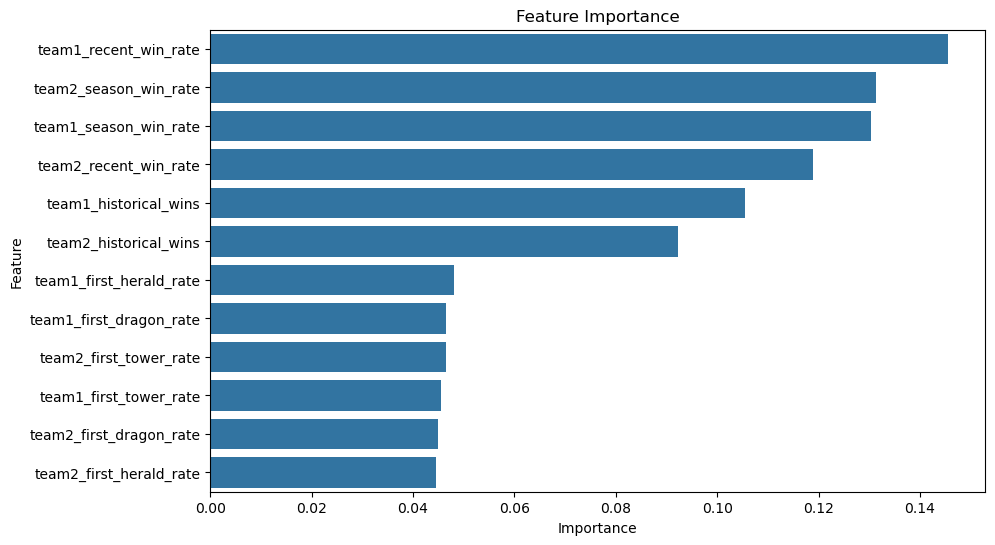

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns  # Import Seaborn for visualization

# 特征重要性分析
feature_importance = pd.DataFrame({
    "Feature": X_pg.columns,
    "Importance": pg_model.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n特征重要性:\n", feature_importance)

# 可视化特征重要性
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.title("Feature Importance")
plt.show()

Model 1 Train Accuracy: 0.7111786871157533
Model 1 Test Accuracy: 0.701368233194527

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.68      0.68      2333
           1       0.72      0.72      0.72      2710

    accuracy                           0.70      5043
   macro avg       0.70      0.70      0.70      5043
weighted avg       0.70      0.70      0.70      5043

模型已保存为 'model1.pkl'

特征重要性:
          Feature  Importance
0   golddiffat10    0.492442
1     xpdiffat10    0.232880
2     csdiffat10    0.158326
3  team1_kdaat10    0.066097
4  team2_kdaat10    0.050255


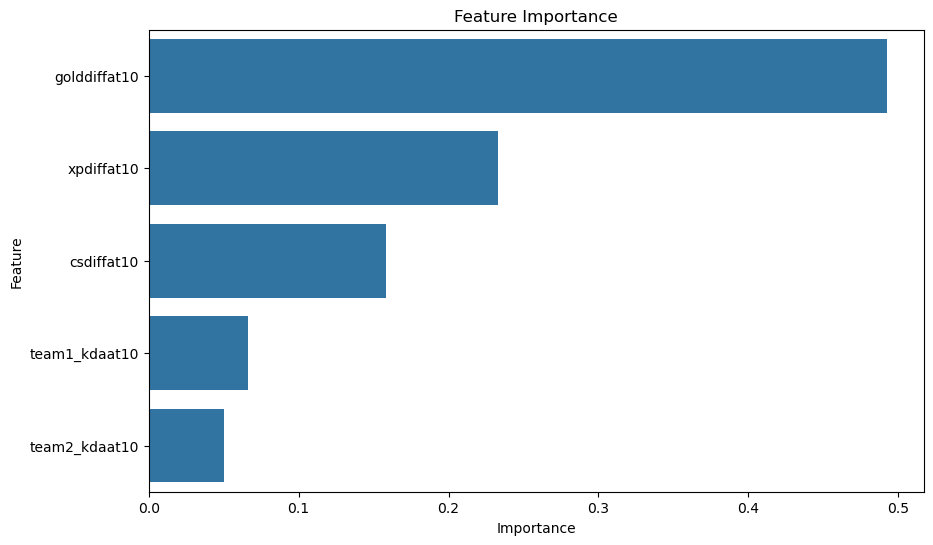

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# 读取数据
df = pd.read_excel("'data/2023&2024&2025data.xlsx")

# 特征工程 - model1（前期10分钟）
X1 = df[['golddiffat10', 'xpdiffat10', 'csdiffat10',  'team1_kdaat10', 'team2_kdaat10']]
y1 = df['result']

# 划分训练集和测试集（保持时序性）
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.25, shuffle=False)

# 训练模型1
model1 = RandomForestClassifier(
    n_estimators=100,
    max_depth=7,
    min_samples_split=10,
    class_weight="balanced",
    random_state=42
)
model1.fit(X_train1, y_train1)

# 训练集评估
y_train_pred1 = model1.predict(X_train1)
print("Model 1 Train Accuracy:", accuracy_score(y_train1, y_train_pred1))

# 测试集评估
y_pred1 = model1.predict(X_test1)
print("Model 1 Test Accuracy:", accuracy_score(y_test1, y_pred1))
print("\nClassification Report:\n", classification_report(y_test1, y_pred1))

# 保存模型
with open('model1.pkl', 'wb') as model_file:
    pickle.dump(model1, model_file)
    print("模型已保存为 'model1.pkl'")


import matplotlib.pyplot as plt
import seaborn as sns  # Import Seaborn for visualization

# 特征重要性分析
feature_importance = pd.DataFrame({
    "Feature": X1.columns,
    "Importance": model1.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n特征重要性:\n", feature_importance)

# 可视化特征重要性
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.title("Feature Importance")
plt.show()

Model 2 Train Accuracy: 0.813708477937531
Model 2 Test Accuracy: 0.7476450173525038

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.73      0.72      1836
           1       0.77      0.76      0.77      2198

    accuracy                           0.75      4034
   macro avg       0.75      0.75      0.75      4034
weighted avg       0.75      0.75      0.75      4034

模型已保存为 'model2.pkl'

特征重要性:
               Feature  Importance
0        golddiffat15    0.315833
1          xpdiffat15    0.187906
2          csdiffat15    0.122682
3       team1_kdaat15    0.096987
8          firsttower    0.082755
4       team2_kdaat15    0.078372
9   team1turretplates    0.041976
10  team2turretplates    0.033450
6         firstdragon    0.024079
7         firstherald    0.009506
5          firstblood    0.006453


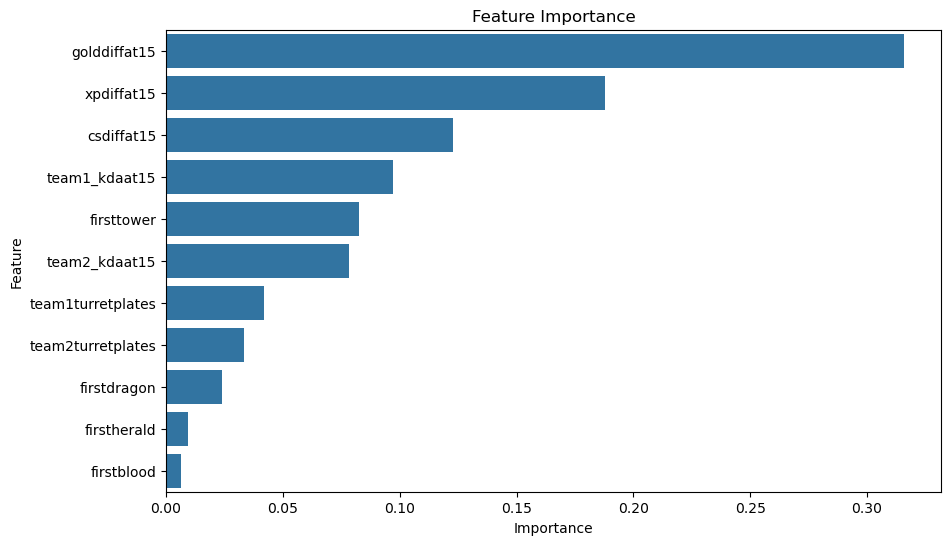

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# 读取数据
df = pd.read_excel("data/2023&2024&2025data.xlsx")

# 特征工程
X = df[['golddiffat15', 'xpdiffat15', 'csdiffat15', 'team1_kdaat15',
        'team2_kdaat15', 'firstblood', 'firstdragon', 'firstherald', 'firsttower', 
        'team1turretplates', 'team2turretplates']]

# 创建目标变量
y = df['result']

# 特征工程 - model2（15分钟）
X2 = df[['golddiffat15', 'xpdiffat15', 'csdiffat15', 'team1_kdaat15',
         'team2_kdaat15', 'firstblood', 'firstdragon', 'firstherald', 'firsttower', 
         'team1turretplates', 'team2turretplates']]
y2 = df['result']

# 划分数据
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, shuffle=False)

# 训练模型2
model2 = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    class_weight="balanced",
    random_state=42
)
model2.fit(X_train2, y_train2)

# 训练集评估
y_train_pred2 = model2.predict(X_train2)
print("Model 2 Train Accuracy:", accuracy_score(y_train2, y_train_pred2))

# 测试集评估
y_pred2 = model2.predict(X_test2)
print("Model 2 Test Accuracy:", accuracy_score(y_test2, y_pred2))
print("\nClassification Report:\n", classification_report(y_test2, y_pred2))

# 保存模型
with open('model2.pkl', 'wb') as model_file:
    pickle.dump(model2, model_file)
    print("模型已保存为 'model2.pkl'")


import matplotlib.pyplot as plt
import seaborn as sns  # Import Seaborn for visualization

# 特征重要性分析
feature_importance = pd.DataFrame({
    "Feature": X2.columns,
    "Importance": model2.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n特征重要性:\n", feature_importance)

# 可视化特征重要性
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.title("Feature Importance")
plt.show()




Model 3 Train Accuracy: 0.8771867696012465
Model 3 Test Accuracy: 0.8472979672781359

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.84      2831
           1       0.85      0.86      0.86      3220

    accuracy                           0.85      6051
   macro avg       0.85      0.85      0.85      6051
weighted avg       0.85      0.85      0.85      6051

模型已保存为 'model3.pkl'

特征重要性:
               Feature  Importance
11         firstbaron    0.360707
0        golddiffat15    0.174362
1          xpdiffat15    0.128194
12      firstmidtower    0.090541
2          csdiffat15    0.059752
3       team1_kdaat15    0.050154
4       team2_kdaat15    0.040326
8          firsttower    0.036679
9   team1turretplates    0.022400
10  team2turretplates    0.018020
6         firstdragon    0.010615
5          firstblood    0.004422
7         firstherald    0.003828


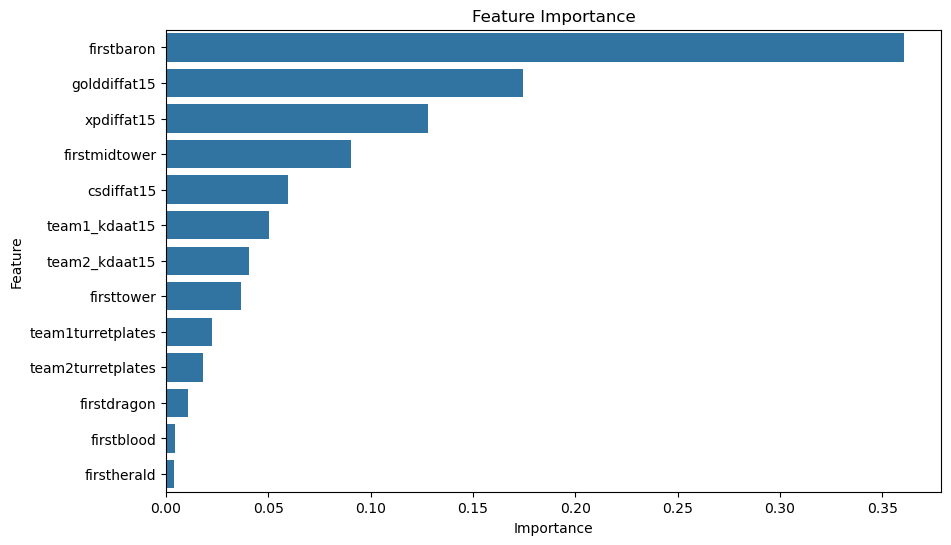

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # 添加模型保存模块

# 读取数据
df = pd.read_excel("data/2023&2024&2025data.xlsx")

# 特征工程 - model3（中后期）
X3 = df[['golddiffat15', 'xpdiffat15', 'csdiffat15', 'team1_kdaat15',
         'team2_kdaat15', 'firstblood', 'firstdragon', 'firstherald', 'firsttower', 
         'team1turretplates', 'team2turretplates', 'firstbaron', 'firstmidtower']]
y3 = df['result']

# 划分数据
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3, shuffle=False)

# 训练模型3
model3 = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    class_weight="balanced",
    random_state=42
)
model3.fit(X_train3, y_train3)

# 训练集评估
y_train_pred3 = model3.predict(X_train3)
print("Model 3 Train Accuracy:", accuracy_score(y_train3, y_train_pred3))

# 测试集评估
y_pred3 = model3.predict(X_test3)
print("Model 3 Test Accuracy:", accuracy_score(y_test3, y_pred3))
print("\nClassification Report:\n", classification_report(y_test3, y_pred3))

# 保存模型
with open('model3.pkl', 'wb') as model_file:
    pickle.dump(model3, model_file)
    print("模型已保存为 'model3.pkl'")


# 特征重要性可视化
feature_importance = pd.DataFrame({
    "Feature": X3.columns,
    "Importance": model3.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n特征重要性:\n", feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.title("Feature Importance")
plt.show()


In [ ]:
models_dict = {
    "Pre-game": (pg_model, X_test_pg, y_test_pg),
    "Early Game (10min)": (model1, X_test1, y_test1),
    "Mid Game (15min)": (model2, X_test2, y_test2),
    "Late Game (15+min)": (model3, X_test3, y_test3)
}

results = []
# 使用其中一个测试集来计算 Baseline（这里以 Pre-game 测试集为例）
baseline_acc = y_test_pg.value_counts(normalize=True).max()

results.append({
    "Model": "Baseline",
    "Accuracy": baseline_acc,
    "F1 Score (Win)": 0.0,
    "F1 Score (Lose)": 0.0
})

# 遍历 models_dict 计算每个模型在各自测试集上的表现
for name, (model, X_test, y_test) in models_dict.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1_win = report['1']['f1-score']
    f1_lose = report['0']['f1-score']
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1 Score (Win)": f1_win,
        "F1 Score (Lose)": f1_lose
    })

# 转换为 DataFrame
df_results = pd.DataFrame(results)
print("\nModel Performance Comparison Table:")
print(df_results)

# 绘制 Accuracy 柱状图
plt.figure(figsize=(8, 6))
plt.bar(df_results["Model"], df_results["Accuracy"], color="steelblue", edgecolor='black')
plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0.5, 0.8)
plt.xticks(rotation=15, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# 绘制 F1 Score 柱状图（Win vs Lose）
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = range(len(df_results))
plt.bar([i - bar_width/2 for i in x], df_results["F1 Score (Win)"], width=bar_width,
        label="F1 Score (Win)", color="seagreen", edgecolor='black')
plt.bar([i + bar_width/2 for i in x], df_results["F1 Score (Lose)"], width=bar_width,
        label="F1 Score (Lose)", color="indianred", edgecolor='black')
plt.xticks(x, df_results["Model"], rotation=15, fontsize=10)
plt.title("F1 Score Comparison (Win vs Lose)", fontsize=14)
plt.ylabel("F1 Score", fontsize=12)
plt.ylim(0.0, 0.85)
plt.legend(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()



In [6]:
import pandas as pd
from sklearn.metrics import accuracy_score

# 读取数据
df_pg = pd.read_csv('data/pre-game.csv')

# 特征与结果
X_pg = df_pg[['team1_historical_wins', 'team2_historical_wins', 
              'team1_recent_win_rate', 'team2_recent_win_rate',
              'team1_season_win_rate', 'team2_season_win_rate',
              'team1_first_dragon_rate', 'team1_first_herald_rate', 'team1_first_tower_rate', 
              'team2_first_dragon_rate', 'team2_first_tower_rate','team2_first_herald_rate']]
y_pg = df_pg['result']

# 划分数据集
from sklearn.model_selection import train_test_split
X_train_pg, X_test_pg, y_train_pg, y_test_pg = train_test_split(X_pg, y_pg, test_size=0.1, random_state=42)

# 训练完整模型
from sklearn.ensemble import RandomForestClassifier
pg_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_split=10,
    class_weight="balanced",
    random_state=42
)
pg_model.fit(X_train_pg, y_train_pg)

# 完整模型准确率
full_model_accuracy_pg = pg_model.score(X_test_pg, y_test_pg)

# 简单规则的特征分组
simple_feature_mapping = {
    'historical_wins': ['team1_historical_wins', 'team2_historical_wins'],
    'recent_win_rate': ['team1_recent_win_rate', 'team2_recent_win_rate'],
    'season_win_rate': ['team1_season_win_rate', 'team2_season_win_rate'],
    'first_dragon_rate': ['team1_first_dragon_rate', 'team2_first_dragon_rate'],
    'first_herald_rate': ['team1_first_herald_rate', 'team2_first_herald_rate'],
    'first_tower_rate': ['team1_first_tower_rate', 'team2_first_tower_rate']
}

# 计算每个逻辑特征对应的简单规则准确率
results_pg = []

for logical_feature, feature_pair in simple_feature_mapping.items():
    f1, f2 = feature_pair
    preds = (X_test_pg[f1] > X_test_pg[f2]).astype(int)
    acc = accuracy_score(y_test_pg, preds)
    results_pg.append({'Feature': logical_feature, 'Simple Rule Accuracy': acc})

# 整理成DataFrame
df_pg_result = pd.DataFrame(results_pg)

# 第一行加上完整模型准确率
df_pg_result['Full Model Accuracy'] = full_model_accuracy_pg

print("Pre-Game阶段最终合理版对比表：")
print(df_pg_result)


Pre-Game阶段最终合理版对比表：
             Feature  Simple Rule Accuracy  Full Model Accuracy
0    historical_wins              0.572414             0.636991
1    recent_win_rate              0.598746             0.636991
2    season_win_rate              0.600627             0.636991
3  first_dragon_rate              0.482759             0.636991
4  first_herald_rate              0.498433             0.636991
5   first_tower_rate              0.483386             0.636991


In [11]:
import pandas as pd
from sklearn.metrics import accuracy_score

# 特征定义
features_early = ['golddiffat10', 'xpdiffat10', 'csdiffat10', 'team1_kdaat10', 'team2_kdaat10']

# 完整模型准确率
full_model_accuracy_early = model1.score(X_test1, y_test1)

# 合理的简单规则
simple_feature_mapping_early = {
    'gold_diff_10': 'golddiffat10',
    'xp_diff_10': 'xpdiffat10',
    'cs_diff_10': 'csdiffat10',
    'kda_diff_10': ('team1_kdaat10', 'team2_kdaat10')
}

results_early = []

for logical_feature, feature in simple_feature_mapping_early.items():
    if isinstance(feature, tuple):  # 需要team1 vs team2对比
        preds = (X_test1[feature[0]] > X_test1[feature[1]]).astype(int)
    else:  # 差值特征 > 0
        preds = (X_test1[feature] > 0).astype(int)
    
    acc = accuracy_score(y_test1, preds)
    results_early.append({'Feature': logical_feature, 'Simple Rule Accuracy': acc})

df_early_result = pd.DataFrame(results_early)
df_early_result['Full Model Accuracy'] = full_model_accuracy_early

print("Early Game阶段最终合理版对比表：")
print(df_early_result)


Early Game阶段最终合理版对比表：
        Feature  Simple Rule Accuracy  Full Model Accuracy
0  gold_diff_10              0.692445             0.701368
1    xp_diff_10              0.657545             0.701368
2    cs_diff_10              0.649415             0.701368
3   kda_diff_10              0.631569             0.701368


In [14]:
# Mid Game特征
features_mid = [
    'golddiffat15', 'xpdiffat15', 'csdiffat15',
    'team1_kdaat15', 'team2_kdaat15',
    'firstblood', 'firstdragon', 'firstherald', 'firsttower',
    'team1turretplates', 'team2turretplates'
]

# 完整模型准确率
full_model_accuracy_mid = model2.score(X_test2, y_test2)

# 合理的简单规则
simple_feature_mapping_mid = {
    'gold_diff_15': 'golddiffat15',
    'xp_diff_15': 'xpdiffat15',
    'cs_diff_15': 'csdiffat15',
    'kda_diff_15': ('team1_kdaat15', 'team2_kdaat15'),
    'first_blood': 'firstblood',
    'first_dragon': 'firstdragon',
    'first_herald': 'firstherald',
    'first_tower': 'firsttower',
    'turret_plate_diff': ('team1turretplates', 'team2turretplates')
}

results_mid = []

for logical_feature, feature in simple_feature_mapping_mid.items():
    if isinstance(feature, tuple):
        preds = (X_test2[feature[0]] > X_test2[feature[1]]).astype(int)
    elif feature in ['firstblood', 'firstdragon', 'firstherald', 'firsttower']:  # 二值特征
        preds = (X_test2[feature] == 1).astype(int)
    else:
        preds = (X_test2[feature] > 0).astype(int)
    
    acc = accuracy_score(y_test2, preds)
    results_mid.append({'Feature': logical_feature, 'Simple Rule Accuracy': acc})

df_mid_result = pd.DataFrame(results_mid)
df_mid_result['Full Model Accuracy'] = full_model_accuracy_mid

print("Mid Game阶段最终合理版对比表：")
print(df_mid_result)


Mid Game阶段最终合理版对比表：
             Feature  Simple Rule Accuracy  Full Model Accuracy
0       gold_diff_15              0.733763             0.747645
1         xp_diff_15              0.709717             0.747645
2         cs_diff_15              0.668815             0.747645
3        kda_diff_15              0.687903             0.747645
4        first_blood              0.600892             0.747645
5       first_dragon              0.603867             0.747645
6       first_herald              0.580813             0.747645
7        first_tower              0.683441             0.747645
8  turret_plate_diff              0.659643             0.747645


In [15]:
# Late Game特征
features_late = [
    'golddiffat15', 'xpdiffat15', 'csdiffat15',
    'team1_kdaat15', 'team2_kdaat15',
    'firstblood', 'firstdragon', 'firstherald', 'firsttower',
    'team1turretplates', 'team2turretplates',
    'firstbaron', 'firstmidtower'
]

# 完整模型准确率
full_model_accuracy_late = model3.score(X_test3, y_test3)

# 合理的简单规则
simple_feature_mapping_late = {
    'gold_diff_15': 'golddiffat15',
    'xp_diff_15': 'xpdiffat15',
    'cs_diff_15': 'csdiffat15',
    'kda_diff_15': ('team1_kdaat15', 'team2_kdaat15'),
    'first_blood': 'firstblood',
    'first_dragon': 'firstdragon',
    'first_herald': 'firstherald',
    'first_tower': 'firsttower',
    'turret_plate_diff': ('team1turretplates', 'team2turretplates'),
    'first_baron': 'firstbaron',
    'first_mid_tower': 'firstmidtower'
}

results_late = []

for logical_feature, feature in simple_feature_mapping_late.items():
    if isinstance(feature, tuple):
        preds = (X_test3[feature[0]] > X_test3[feature[1]]).astype(int)
    elif feature in ['firstblood', 'firstdragon', 'firstherald', 'firsttower', 'firstbaron', 'firstmidtower']:
        preds = (X_test3[feature] == 1).astype(int)
    else:
        preds = (X_test3[feature] > 0).astype(int)
    
    acc = accuracy_score(y_test3, preds)
    results_late.append({'Feature': logical_feature, 'Simple Rule Accuracy': acc})

df_late_result = pd.DataFrame(results_late)
df_late_result['Full Model Accuracy'] = full_model_accuracy_late

print("Late Game阶段最终合理版对比表：")
print(df_late_result)


Late Game阶段最终合理版对比表：
              Feature  Simple Rule Accuracy  Full Model Accuracy
0        gold_diff_15              0.739547             0.847298
1          xp_diff_15              0.704512             0.847298
2          cs_diff_15              0.673938             0.847298
3         kda_diff_15              0.685011             0.847298
4         first_blood              0.602049             0.847298
5        first_dragon              0.610147             0.847298
6        first_herald              0.579408             0.847298
7         first_tower              0.689142             0.847298
8   turret_plate_diff              0.667989             0.847298
9         first_baron              0.821021             0.847298
10    first_mid_tower              0.717402             0.847298


In [18]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# 先分别生成每个模型的预测结果
# （你之前已经有 y_pred 了，不过我这里统一一下写法）

# Pre-Game
y_pred_pg = pg_model.predict(X_test_pg)
report_pg = classification_report(y_test_pg, y_pred_pg, output_dict=True)

# Early-Game
y_pred_early = model1.predict(X_test1)
report_early = classification_report(y_test1, y_pred_early, output_dict=True)

# Mid-Game
y_pred_mid = model2.predict(X_test2)
report_mid = classification_report(y_test2, y_pred_mid, output_dict=True)

# Late-Game
y_pred_late = model3.predict(X_test3)
report_late = classification_report(y_test3, y_pred_late, output_dict=True)

# 整理成统一表格，只关心 'accuracy', 'precision', 'recall', 'f1-score'
results_summary = pd.DataFrame({
    'Stage': ['Pre-Game', 'Early-Game (10 min)', 'Mid-Game (15 min)', 'Late-Game'],
    'Accuracy': [
        accuracy_score(y_test_pg, y_pred_pg),
        accuracy_score(y_test1, y_pred_early),
        accuracy_score(y_test2, y_pred_mid),
        accuracy_score(y_test3, y_pred_late)
    ],
    'Precision': [
        report_pg['weighted avg']['precision'],
        report_early['weighted avg']['precision'],
        report_mid['weighted avg']['precision'],
        report_late['weighted avg']['precision']
    ],
    'Recall': [
        report_pg['weighted avg']['recall'],
        report_early['weighted avg']['recall'],
        report_mid['weighted avg']['recall'],
        report_late['weighted avg']['recall']
    ],
    'F1-score': [
        report_pg['weighted avg']['f1-score'],
        report_early['weighted avg']['f1-score'],
        report_mid['weighted avg']['f1-score'],
        report_late['weighted avg']['f1-score']
    ]
})

# 显示最终表格
print(results_summary)


                 Stage  Accuracy  Precision    Recall  F1-score
0             Pre-Game  0.636991   0.638644  0.636991  0.637437
1  Early-Game (10 min)  0.701368   0.701559  0.701368  0.701452
2    Mid-Game (15 min)  0.747645   0.747842  0.747645  0.747732
3            Late-Game  0.847298   0.847233  0.847298  0.847242
